In [75]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient 
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
%matplotlib inline
import matplotlib.pyplot as plt
import re

In [3]:
# uri (uniform resource identifier) defines the connection parameters 
uri = 'mongodb://127.0.0.1:27017'
# start client to connect to MongoDB server 
client = MongoClient( uri )
db = client.JiraRepos

# Functions

In [4]:
def lexicon_to_array():
    lexicon = pd.read_csv('Harassment Lexicon.csv')
    arr = lexicon.fillna('').astype(str).values.flatten().tolist()
    # Ditch some words here with special characters.
    return [i for i in arr if i and not re.search("[()*!?]", i)]

def lexicon_to_space_delimited():
    return " ".join(lexicon_to_array())

In [62]:
def aggregate_to_df(collection):
    cursor = collection.aggregate([
#        { "$sample": { "size": 1000 } },
        { "$match": { "fields.comments": { "$exists": True, "$ne": [] }}},
        { "$limit": 1000 },
        { "$replaceWith": { "comments": "$fields.comments" }},
        { "$unwind": { "path": "$comments" }},
        { "$replaceRoot": { "newRoot": "$comments" }},
        { "$group": {
            "_id": "$author.key",
            "firstCommentDate": {
                "$min": { "$dateFromString": { "dateString": "$created" } }
            },
            "lastCommentDate": {
                "$max": { "$dateFromString": { "dateString": "$created" } }
            },
            "numComments": { "$count": {} },
            "comments": { "$addToSet": "$body" }
        }},
        { "$addFields": {
            "activeness": {
                "$cond": [
                    { "$subtract": ["$lastCommentDate", "$firstCommentDate"] },
                    { "$divide": [
                        "$numComments",
                        { "$subtract": ["$lastCommentDate", "$firstCommentDate"] },
                    ]},
                    0
                ]
            },
            "numToxicComments": {
                "$reduce": {
                    "input": "$comments",
                    "initialValue": 0,
                    "in": {
                        "$add": ["$$value", {
                            "$toInt": {
                                "$regexMatch": {
                                    "input": "$$this",
                                    "regex": "/" + "|".join(lexicon_to_array()) + "/",
                                    "options": "i"
                                }
                            }
                        }]
                    }
                }
            }
        }}, { "$addFields": {
            "toxicity": {
                "$divide": ["$numToxicComments", "$numComments"]
            }
        }}
    ])
    df = pd.DataFrame(list(cursor))
    return df

merged_df = None

collections = db.list_collection_names()
progress_bar = tqdm(collections)
for collection in progress_bar:
    df = aggregate_to_df(db[collection])
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.concat([merged_df, df], axis=0)

merged_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:29<00:00,  9.35s/it]


,_id,firstCommentDate,lastCommentDate,numComments,comments,activeness,numToxicComments,toxicity
0,haribabu.kommi,2021-04-21 13:11:04,2022-01-07 05:02:19,185,[Hit again:\r\nhttps://evergreen.mongodb.com/t...,8.214528e-09,76,0.410811
1,dan@10gen.com,2021-07-07 16:01:33,2021-07-07 16:01:33,1,[does not appear on the surface to warrant a r...,0.000000e+00,0,0.000000
2,JIRAUSER1260529,2021-07-28 13:39:24,2021-07-28 13:39:24,1,"[Hi [~keith.bostic],\r\n\r\nThanks for your re...",0.000000e+00,1,1.000000
3,luke.pearson,2021-05-03 02:35:46,2022-01-07 01:59:24,252,[These failures are proving to be relatively d...,1.171471e-08,90,0.357143
4,louis.williams,2021-04-21 14:59:54,2022-01-04 12:07:07,33,"[Hey [~chenhao.qu], apologies for the delay. I...",1.481094e-09,10,0.303030


In [63]:
merged_df = merged_df.reset_index()

In [64]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             5404 non-null   int64         
 1   _id               5401 non-null   object        
 2   firstCommentDate  5404 non-null   datetime64[ns]
 3   lastCommentDate   5404 non-null   datetime64[ns]
 4   numComments       5404 non-null   int64         
 5   comments          5404 non-null   object        
 6   activeness        5404 non-null   float64       
 7   numToxicComments  5404 non-null   int64         
 8   toxicity          5404 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 380.1+ KB


In [83]:
merged_df_adj = merged_df[(merged_df["numComments"] > 10) & (merged_df["activeness"] < 0.51e-7)]
merged_df_adj["activeness_log"] = np.log(merged_df_adj["activeness"]);

C:\Users\Pim\AppData\Local\Temp/ipykernel_11544/4019863435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_adj["activeness_log"] = np.log(merged_df_adj["activeness"]);


In [80]:
merged_df_adj_tst = merged_df[(merged_df["numComments"] > 10) & (merged_df["activeness"] > 0.51e-7)]
merged_df_adj_tst.head()

,index,_id,firstCommentDate,lastCommentDate,numComments,comments,activeness,numToxicComments,toxicity
18,18,xgen-internal-githook,2021-04-22 00:06:08.000,2022-01-11 05:53:08.000,3246,"[Author:{'name': 'Alexey Anisimov', 'email': '...",1.421787e-07,2431,0.748922
68,68,JIRAUSER1259052,2021-10-06 16:06:22.000,2021-10-06 16:17:18.000,294,[Updating the fixversion since branching activ...,4.481707e-04,1,0.003401
988,553,JIRAUSER4589831,2020-10-30 10:45:25.141,2020-11-20 13:02:51.616,95,"[Cannot Reproduce on 3.3.9,, Hello, could you ...",5.212201e-08,4,0.042105
2056,372,tero.kojo,2014-01-29 09:58:17.000,2014-02-04 12:13:32.000,42,"[This feature is nice to have, but not a reali...",7.976981e-08,6,0.142857
2633,3,jorlina,2021-12-09 16:25:29.901,2022-01-12 15:45:00.910,407,[The issue is related to extraordinary load on...,1.386631e-07,86,0.211302


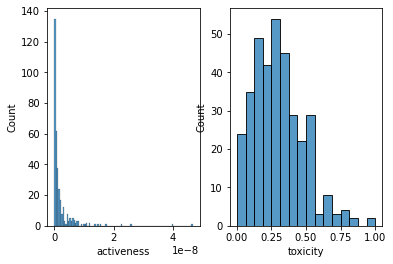

In [86]:
fig, ax = plt.subplots(1, 2)
sns.histplot(merged_df_adj, x="activeness", bins=100, ax=ax[0])
sns.histplot(merged_df_adj, x="toxicity", ax=ax[1]);

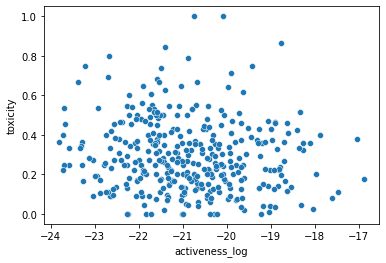

In [89]:
sns.scatterplot(data=merged_df_adj, x="activeness_log", y="toxicity");